In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [129]:
def plot_failure_rate_by_column(df, column, project_type):
    """
    Plots the failure rate by a given column in the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column (str): The column to group by and plot the failure rate.
    status_filter (str): The project status to filter on. Used for the chart title.
    threshold (float): An optional threshold to filter the failure rate. Defaults to None.
    
    Returns:
    None
    """
    # Calculate the failure rate and the ratio of num_failed/total
    grouped = df.groupby(column).agg(
        num_failed=('failure', 'sum'),
        total=('failure', 'size')
    )
    grouped['failure_rate'] = grouped['num_failed'] / grouped['total']
    
    # Filter out entries with 0 failure rate
    grouped = grouped[grouped['failure_rate'] > 0]
    grouped = grouped.head(20)
    
    # Sort the failure rate
    grouped = grouped.sort_values(by='failure_rate', ascending=False)
    
    # Plot the failure rate
    plt.figure(figsize=(12, 8))
    bars = plt.bar(grouped.index, grouped['failure_rate'], color='skyblue')
    plt.title(f'Failure Rate of {project_type} projects by {column}')
    # plt.title(f'Failure Rate by {column.replace("_", " ").title()} (where project status == "{status_filter}")')
    plt.xlabel(column.replace('_', ' ').title())
    plt.ylabel('Failure Rate')
    plt.xticks(rotation=45, ha='right')
    
    # Add text annotations on top of the bars
    for bar, num_failed, total in zip(bars, grouped['num_failed'], grouped['total']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{num_failed}/{total}', 
                 ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
def plot_based_on_failure(df, col, bins=10):
    """
    Plots the distribution of the difference in days based on failure condition.

    Parameters:
    - df: pandas DataFrame containing the data.
    - bins: number of bins for the histogram (default is 10).
    """
    # Separate the data based on the condition of failure
    df_failed = df[df['failure']][col]
    df_succeeded = df[~df['failure']][col]

    # Plot the distributions
    plt.figure(figsize=(10, 6))
    plt.hist(df_failed, bins=bins, alpha=0.5, label=f'failure = True')
    plt.hist(df_succeeded, bins=bins, alpha=0.5, label=f'failure = False')

    # Adding titles and labels
    plt.title('Distribution of start_and_planned_end_diff based on failure')
    plt.xlabel('col')
    plt.ylabel('Frequency')
    plt.legend()

    # Show plot
    plt.show()

def calculate_failure_rate(df, column='failure'):
    # Ensure the column exists in the DataFrame
    if column not in df.columns:
        raise ValueError(f"Column '{column}' does not exist in the DataFrame.")
    
    # Calculate the count of False values
    false_count = df[column].value_counts().get(True, 0)
    
    # Calculate the total count of non-missing values in the column
    total_count = df[column].notna().sum()
    
    # Avoid division by zero
    if total_count == 0:
        return 0

    # Calculate the failure rate (percentage of False values)
    failure_rate = (false_count / total_count) * 100

    return failure_rate

def plot_failure_rate_by_column(df, column, status_filter, threshold=None):
    """
    Plots the failure rate by a given column in the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column (str): The column to group by and plot the failure rate.
    status_filter (str): The project status to filter on. Used for the chart title.
    threshold (float): An optional threshold to filter the failure rate. Defaults to None.
    
    Returns:
    None
    """
    # Calculate the failure rate and the ratio of num_failed/total
    grouped = df.groupby(column).agg(
        num_failed=('failure', 'sum'),
        total=('failure', 'size')
    )
    grouped['failure_rate'] = grouped['num_failed'] / grouped['total']
    
    # If a threshold is provided, filter the failure rate
    if threshold is not None:
        grouped = grouped[grouped['failure_rate'] >= threshold]
    
    # Filter out entries with 0 failure rate
    grouped = grouped[grouped['failure_rate'] > 0]
    
    # Sort the failure rate
    grouped = grouped.sort_values(by='failure_rate', ascending=False)
    
    # Plot the failure rate
    plt.figure(figsize=(12, 8))
    bars = plt.bar(grouped.index, grouped['failure_rate'], color='skyblue')
    plt.title(f'Failure Rate by {column.replace("_", " ").title()} (where project status == "{status_filter}")')
    plt.xlabel(column.replace('_', ' ').title())
    plt.ylabel('Failure Rate')
    plt.xticks(rotation=45, ha='right')
    
    # Add text annotations on top of the bars
    for bar, num_failed, total in zip(bars, grouped['num_failed'], grouped['total']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{num_failed}/{total}', 
                 ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [130]:
df = pd.read_csv("https://datasocibmproject.s3.ap-southeast-2.amazonaws.com/structured_data/capital_project_schedules_and_budgets_1.csv")
df = df.drop(df.columns[0], axis=1)

In [131]:
# status_filter='In-Progress'
status_filter='Complete'

df = df[df['project_status_name'] == status_filter]
df = df.drop('project_status_name', axis=1)

df.shape

(2981, 14)

In [132]:
fail_rate = calculate_failure_rate(df)
print(f"Failure rate: {fail_rate:.2f}")

Failure rate: 6.98


In [133]:
pd.set_option('display.max_rows', None)

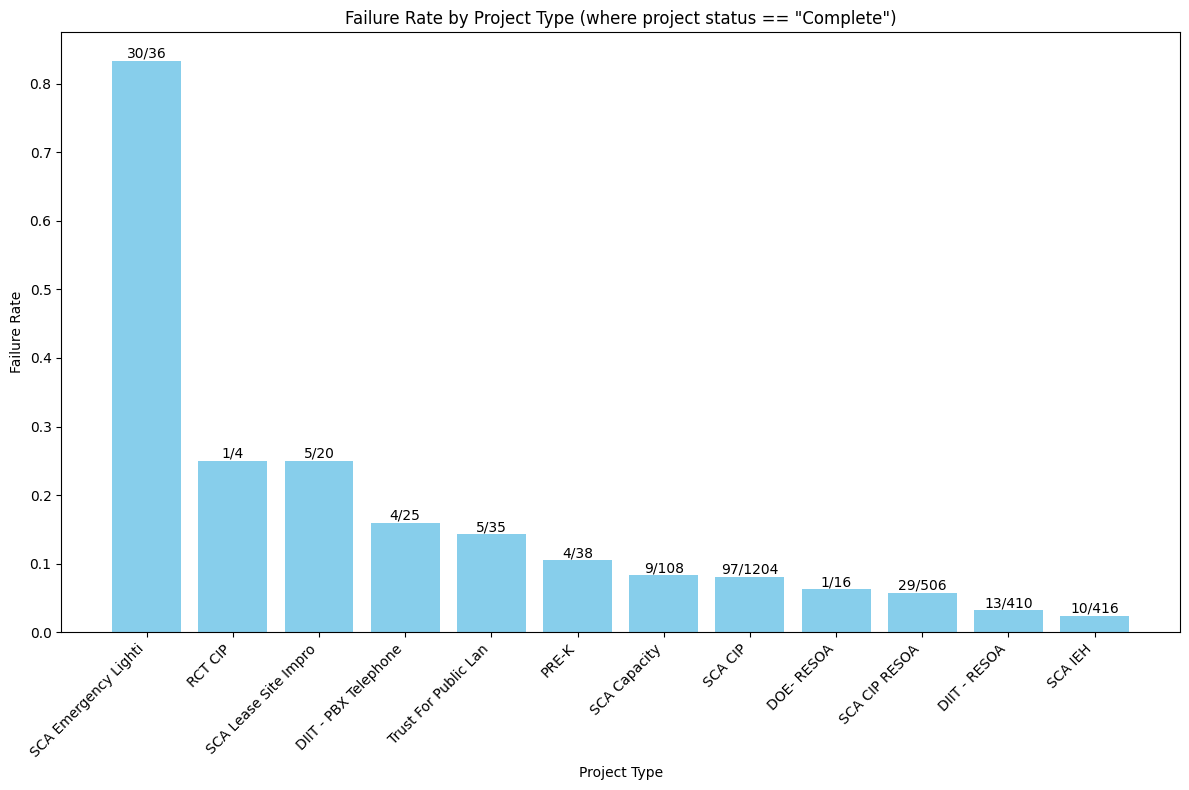

In [134]:
plot_failure_rate_by_column(df, 'project_type', status_filter)

In [135]:
project_types = [
    "SCA", "CIP", "DIIT", "DOE", "DOES", "DOER",
    "RESOA", "IEH", "PRE-K", "DCAS", "FAST TRACK PROJECTS"
]

df = df.map(lambda x: x.replace('PREK', 'PRE-K') if isinstance(x, str) else x)

for project_type in project_types:
    column_name = f"project_type_{project_type.replace(' ', '_')}"
    df[column_name] = df.apply(lambda row: 1 if any(project_type in str(cell) for cell in row) else 0, axis=1)

# df.drop('project_type', axis=1, inplace=True)
df.head()

,project_geographic_district,project_building_identifier,project_school_name,project_type,project_description,project_phase_name,project_phase_actual_start_date,project_phase_planned_end_date,project_phase_actual_end_date,project_budget_amount,...,project_type_CIP,project_type_DIIT,project_type_DOE,project_type_DOES,project_type_DOER,project_type_RESOA,project_type_IEH,project_type_PRE-K,project_type_DCAS,project_type_FAST_TRACK_PROJECTS
2,10,X254,I.S. 254 - BRONX,SCA CIP RESOA,FY16 RESO A IP SURVEILLANCE CAMERA INSTALLATION,Scope,07/27/2017,11/27/2017,08/03/2017,0,...,1,0,0,0,0,1,0,0,0,0
6,10,X254,I.S. 254 - BRONX,DIIT - RESOA,FY17 RESO A TECHNOLOGY,Purch & Install,05/15/2017,01/15/2018,09/14/2017,50000,...,0,1,0,0,0,1,0,0,0,0
7,10,X254,I.S. 254 - BRONX,DIIT - RESOA,FY17 RESO A TECHNOLOGY,Purch & Install,05/15/2017,01/15/2018,09/14/2017,76250,...,0,1,0,0,0,1,0,0,0,0
8,10,X279,P.S. 279 - BRONX,SCA CIP,WATER PENETRATION/ROOFS,Scope,08/02/2016,12/19/2016,02/13/2017,36881,...,1,0,0,0,0,0,0,0,0,0
9,10,X279,P.S. 279 - BRONX,SCA CIP,WATER PENETRATION/ROOFS,Design,05/15/2017,10/16/2017,12/18/2017,141246,...,1,0,0,0,0,0,0,0,0,0


In [136]:
# Feature engineering for boroughs
borough_districts = {
    'manhattan': [i for i in range(1, 7)],
    'bronx': [i for i in range(7, 13)], 
    'brooklyn': [i for i in range(13, 24)] + [32],
    'queens': [i for i in range(24, 31)],
    'staten-island': [31]
}

for borough, districts in borough_districts.items():
    df[borough] = 0
    df.loc[df['project_geographic_district'].isin(districts), borough] = 1

# Function to get the column name with value 1
def map_borough(row):
    for col in borough_districts.keys():
        if row[col] == 1:
            return col
    return None

# Apply the function to create the new column
df['borough'] = df.apply(map_borough, axis=1)
df = df.drop(columns=['project_geographic_district'])

for col in borough_districts.keys():
    df.drop(col, axis=1, inplace=True)

In [137]:
# Converting numerical columns to appropriate types
df['project_budget_amount'] = pd.to_numeric(df['project_budget_amount'], errors='coerce')
df['final_estimate_of_actual_costs_through_end_of_phase_amount'] = pd.to_numeric(df['final_estimate_of_actual_costs_through_end_of_phase_amount'], errors='coerce')
df['total_phase_actual_spending_amount'] = pd.to_numeric(df['total_phase_actual_spending_amount'], errors='coerce')

# Difference between budget and actual spending relative to spending
df['over_budget_percentage'] = ((df['project_budget_amount'] - df['total_phase_actual_spending_amount']) / df['project_budget_amount']).round(2) * 100
df['over_budget_amount'] = df['project_budget_amount'] - df['total_phase_actual_spending_amount']

In [138]:
# Converting date columns to datetime format
df['project_phase_actual_start_date'] = pd.to_datetime(df['project_phase_actual_start_date'], errors='coerce')
df['project_phase_planned_end_date'] = pd.to_datetime(df['project_phase_planned_end_date'], errors='coerce')

df['start_and_planned_end_diff'] = (df['project_phase_planned_end_date'] - df['project_phase_actual_start_date']).dt.days

In [139]:
df.to_csv(f'{status_filter}_cleaned.csv', index=False)
df.shape

(2981, 28)

In [140]:
mean_difference = df['start_and_planned_end_diff'].mean()
median_difference = df['start_and_planned_end_diff'].median()
std_difference = df['start_and_planned_end_diff'].std()

# Print the results
print(f"Mean: {mean_difference}")
print(f"Median: {median_difference}")
print(f"Standard Deviation: {std_difference}")

Mean: 173.52841845140034
Median: 152.0
Standard Deviation: 149.21863933000077


### Filtering by project type

In [141]:
project_type = 'RESOA'
df_subset = df[df[f'project_type_{project_type}'] == 1]

fail_rate = calculate_failure_rate(df_subset)
print(f"Failure rate: {fail_rate:.2f}")

# print(df_subset['project_description'].value_counts())

Failure rate: 4.61


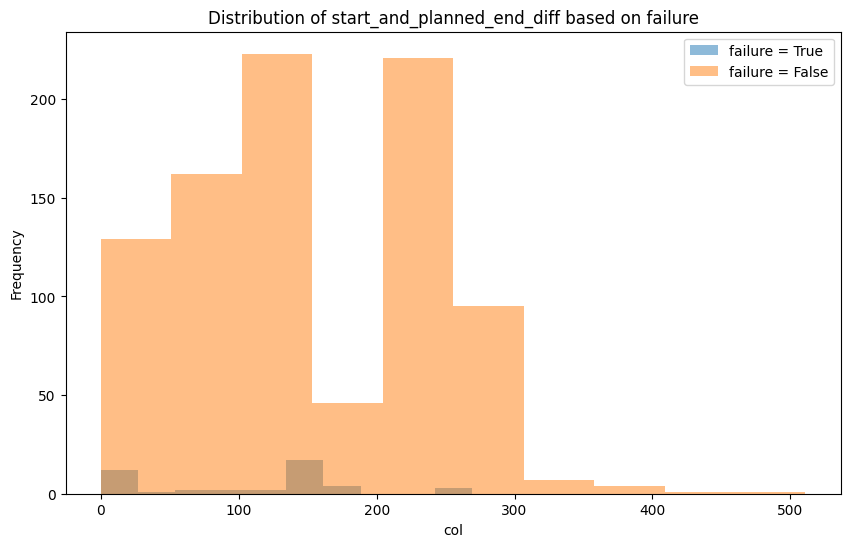

137.0

In [142]:
# Example usage with your DataFrame
plot_based_on_failure(
    df=df_subset, 
    col='start_and_planned_end_diff', 
    bins=10
)

df_subset['start_and_planned_end_diff'].median()

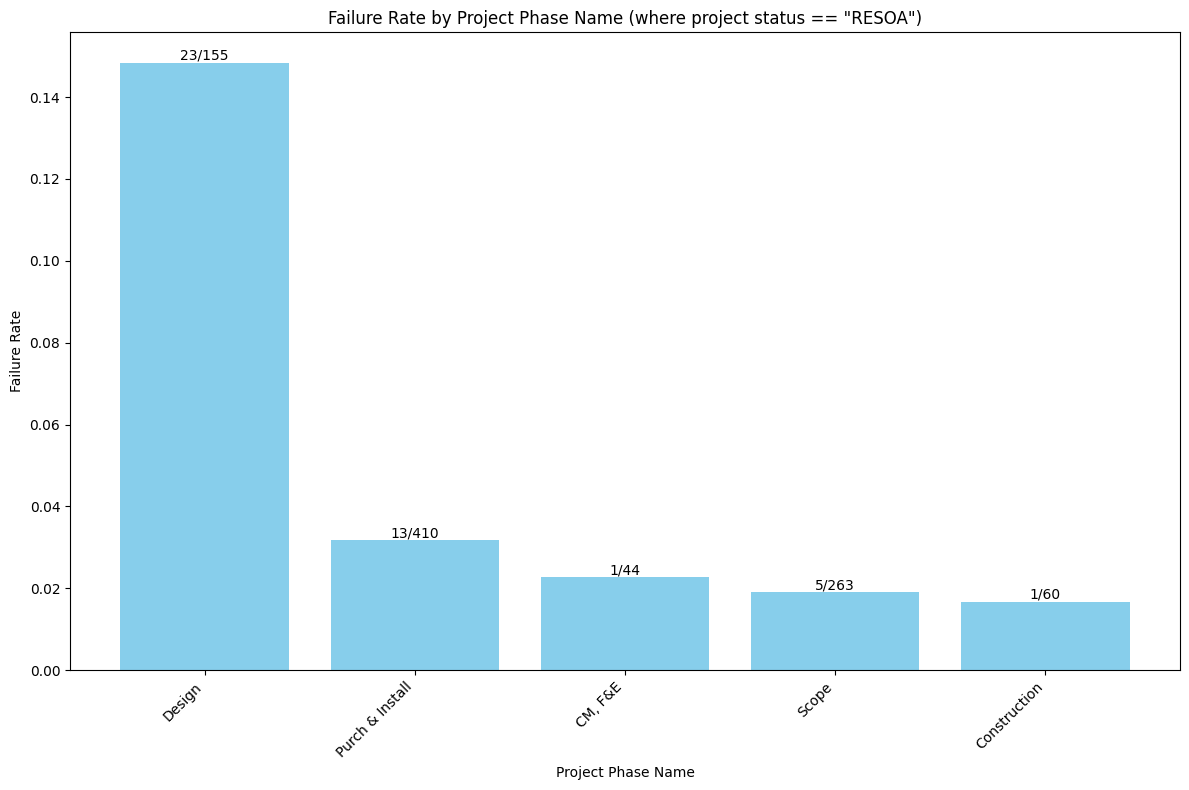

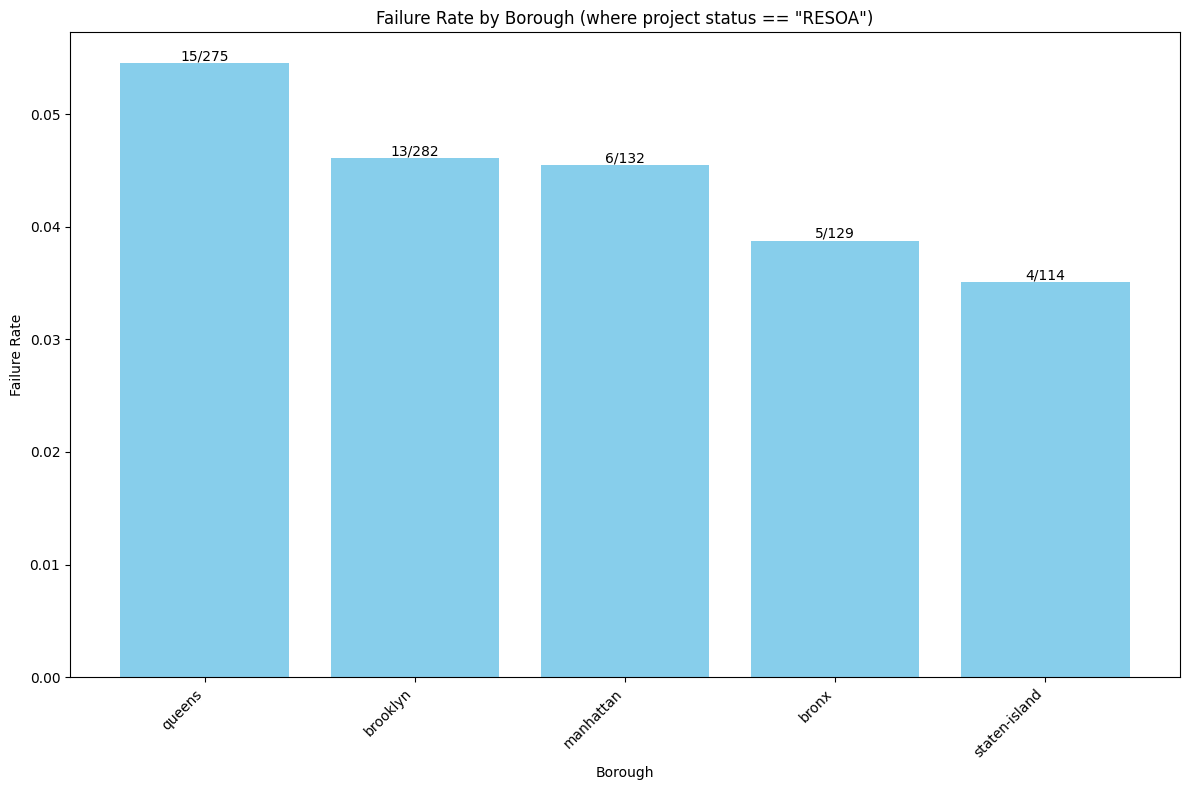

In [143]:
agg_by = 'project_phase_name'
plot_failure_rate_by_column(df_subset, agg_by, project_type)

agg_by = 'borough'
plot_failure_rate_by_column(df_subset, agg_by, project_type)

Budget and cost

In [144]:
# Had a brief look at the budgets here for DIIT projects

# df_subset[df_subset['project_type'].str.contains('RESOA')]
# df_subset[df_subset['project_type'].str.contains('Conne')]

In [145]:
# Separate the data based on the condition of failure
df_failed = df_subset[df_subset['failure']]
df_succeeded = df_subset[~df_subset['failure']]

print(df_failed.shape[0])
print(df_succeeded.shape[0])

43
889


In [146]:
df_subset.loc[:, 'over_budget_percentage'] = df_subset['over_budget_percentage'].replace([np.inf, -np.inf], np.nan)
df_subset.dropna(subset=['over_budget_percentage'], inplace=True)

/var/folders/l7/rfx8sr1s2h32jhyxdrb33h_40000gn/T/ipykernel_55149/2556343740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.dropna(subset=['over_budget_percentage'], inplace=True)


In [147]:
# Separate the data based on the condition of failure
df_failed = df_subset[df_subset['failure']]
df_succeeded = df_subset[~df_subset['failure']]

print(df_failed.shape[0])
print(df_succeeded.shape[0])

38
632


In [148]:
mean_difference = df_subset[df_subset['failure']]['over_budget_percentage'].mean()
median_difference = df_subset[df_subset['failure']]['over_budget_percentage'].median()
std_difference = df_subset[df_subset['failure']]['over_budget_percentage'].std()

# Print the results
print(f"Mean: {mean_difference:.2f}")
print(f"Median: {median_difference:.2f}")
print(f"Standard Deviation: {std_difference:.2f}")

Mean: -137.97
Median: -114.50
Standard Deviation: 178.98


In [149]:
mean_difference = df_subset[~df_subset['failure']]['over_budget_percentage'].mean()
median_difference = df_subset[~df_subset['failure']]['over_budget_percentage'].median()
std_difference = df_subset[~df_subset['failure']]['over_budget_percentage'].std()

# Print the results
print(f"Mean: {mean_difference:.2f}")
print(f"Median: {median_difference:.2f}")
print(f"Standard Deviation: {std_difference:.2f}")

Mean: 6.71
Median: 1.00
Standard Deviation: 31.36


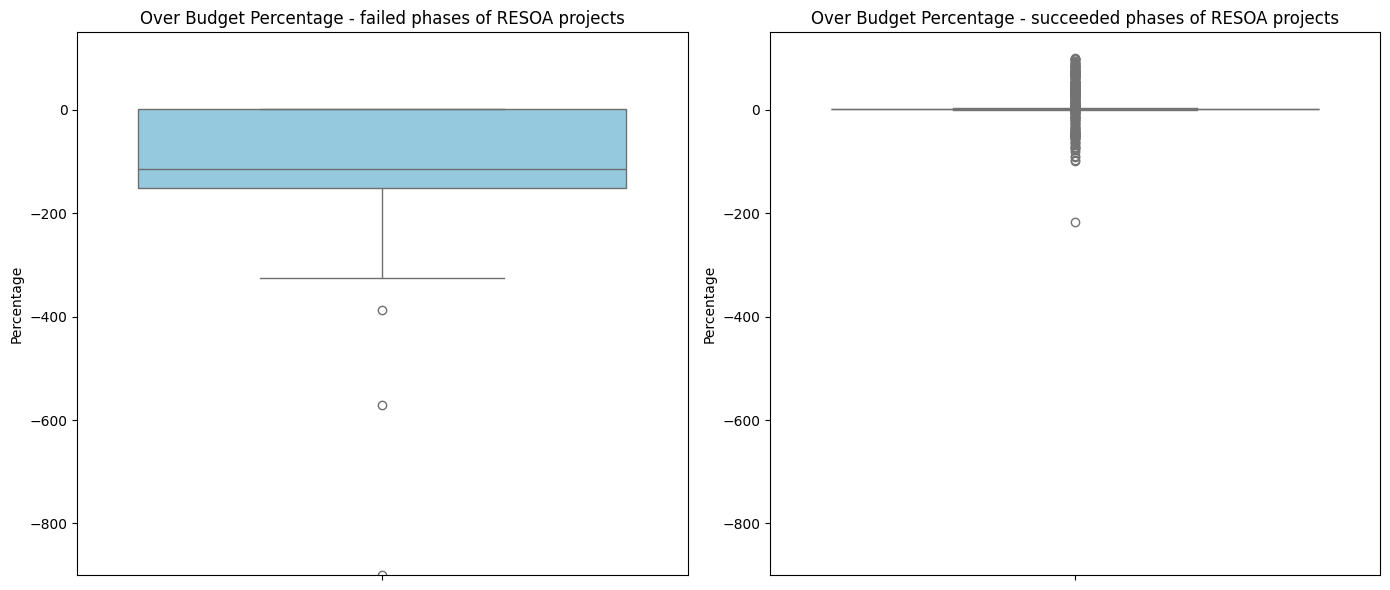

In [150]:
# Determine the common y-axis limits
y_min = min(df_failed['over_budget_percentage'].min(), df_succeeded['over_budget_percentage'].min())
y_max = max(df_failed['over_budget_percentage'].max(), df_succeeded['over_budget_percentage'].max()) + 50


# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot for 'over_budget_percentage'
sns.boxplot(y=df_failed['over_budget_percentage'], color='skyblue', ax=axes[0])
axes[0].set_title(f'Over Budget Percentage - failed phases of {project_type} projects')
axes[0].set_ylabel('Percentage')
axes[0].set_ylim(y_min, y_max)

# Box plot for 'another_metric'
sns.boxplot(y=df_succeeded['over_budget_percentage'], color='lightgreen', ax=axes[1])
axes[1].set_title(f'Over Budget Percentage - succeeded phases of {project_type} projects')
axes[1].set_ylabel('Percentage')
axes[1].set_ylim(y_min, y_max)

# Display the plots
plt.tight_layout()
plt.show()


In [151]:
# # Calculate the median values
# median_values = df.groupby('project_type')['budget_spending_diff'].median().reset_index()

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(median_values['project_type'], median_values['budget_spending_diff'], marker='o', linestyle='-')
# plt.xlabel('project_type')
# plt.ylabel(f'Median of budget_spending_diff')
# plt.title(f'Median of budget_spending_diff by project_type')
# plt.grid(True)
# plt.show()